In [1]:
import geopandas as gpd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import rasterio as rio 
import rioxarray as rioxr
import pandas as pd
import xarray as xr
import pandas
import pickle
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [3]:
class Cfg: 
    size_test=0.3
    seed=12

In [4]:
project_dir = "/home/rustt/Documents/Projects/S1_S2_classification"
data_dir = os.path.join(project_dir, "sentinel_classification/data/processed")
model_dir = os.path.join(project_dir, "sentinel_classification/models")
out_dir = os.path.join(project_dir, "sentinel_classification/data/final")

In [421]:
#s2_stack_path = os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif")
s2_arr = np.load(os.path.join(out_dir, "s2_stack.npy"))
labels =  np.load(os.path.join(out_dir, "labels.npy"))
labels_df = gpd.read_file(os.path.join(data_dir, "ROI_Classif_corrected.shp"))

In [449]:
s2_arr.shape

(442316, 10)

In [ ]:
plt.imshow(s2_arr[:, 3])

In [6]:
with open(os.path.join(data_dir, "band_mapping_stack.pkl"), "rb") as fp: 
    band_mapping = pickle.load(fp)

In [430]:
labels_mapping = labels_df.groupby("classid")["classlabel"].first().to_dict()

In [442]:
# write labels mapping
with open(os.path.join(data_dir, "labels_mapping.pkl"), "wb") as fp: 
    pickle.dump(labels_mapping, fp)

implement factory for stack data sources

retirer les nuages dans un premier temps

In [306]:
df = pd.concat([pd.DataFrame(s2_arr, columns=[str(i) for i in range(s2_arr.shape[1])]), pd.Series(labels, name="label")], axis=1)
df = df[df.label != 13]
s2_arr = df.drop("label", axis=1).values 
labels = df.label.values 
del df

In [363]:
X = s2_arr.copy()
y = labels.copy()

In [364]:
pd.Series(y).value_counts()

6.0     225949
1.0      52132
2.0      48323
4.0      20701
13.0     20424
7.0      18055
12.0     17397
3.0      14679
11.0     13263
5.0      11393
dtype: int64

In [365]:
print(X.shape) 
print(y.shape)

(442316, 10)
(442316,)


### Encode labels

In [368]:
#y = LabelBinarizer().fit_transform(y)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [446]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [447]:
encoder.inverse_transform(y)

array([ 6,  6,  6, ..., 13, 13, 13], dtype=int16)

In [369]:
pd.Series(y).value_counts()

5    225949
0     52132
1     48323
3     20701
9     20424
6     18055
8     17397
2     14679
7     13263
4     11393
dtype: int64

In [448]:
# write labels mapping encoder
with open(os.path.join(model_dir, "encoder_labels.pkl"), "wb") as fp: 
    pickle.dump(encoder, fp)

## Split train/test

### Resample

#### Filter outiers
```python
df = pd.concat([pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])]), pd.Series(y, name="label")], axis=1)

cut_off = lambda x: 1.5 * (np.percentile(x, 75) - np.percentile(x, 25))
lower_f = lambda x:  np.percentile(x, 25) - cut_off(x)
upper_f = lambda x:  np.percentile(x, 75) + cut_off(x)

rm_idx = []
for col in df.columns:
    col_values = df[col].values
    lower_value = lower_f(col_values)
    upper_value = upper_f(col_values)
    rm_c = np.where((df[col] < lower_value) | (df[col] > upper_value))[0].tolist()
    rm_idx.extend(rm_c) 
    
rm_idx = list(set(rm_idx))

X = np.delete(X, rm_idx, axis=0)
y= np.delete(y, rm_idx, axis=0)

print(X.shape)
print(y.shape)

pd.Series(y).value_counts()
```

#### Filter on min sample

In [402]:
min_sample = np.min(pd.Series(y).value_counts())

y_df = pd.Series(y)
y_indices_resample = []
for label in y_df.unique():
    y_label = np.random.choice(np.where(y_df == label)[0], min_sample, replace=False).tolist()
    y_indices_resample.extend(y_label)

y_resample = y[y_indices_resample]
X_resample = X[y_indices_resample, :]

In [451]:
pd.DataFrame(y_resample).value_counts().unique()

array([11393])

In [404]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resample, 
    y_resample, 
    test_size=Cfg.size_test, 
    stratify=y_resample, 
    random_state=Cfg.seed
)

In [405]:
print(X_train.shape)
print(y_train.shape)

(79751, 10)
(79751,)


In [109]:
print(X_test.shape)
print(y_test.shape)

(34179, 10)
(34179,)


In [127]:
df = pd.DataFrame(X_train, columns=[band_mapping[_] for _ in range(X_train.shape[1])])

In [132]:
df.shape

(79751, 10)

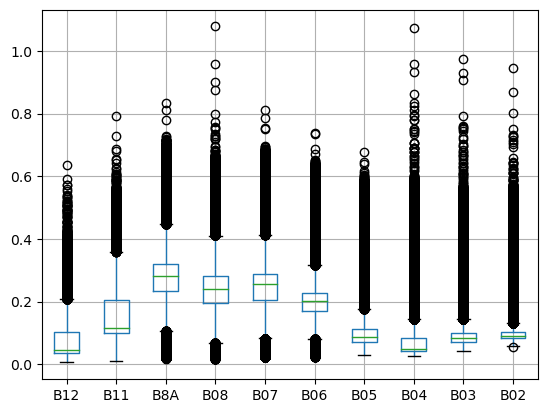

In [151]:
df.boxplot()
plt.show()

* DN ?
* remove outlier

### Training

In [407]:
%%time
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 213 ms, total: 1min 40s
Wall time: 6.97 s


RandomForestClassifier(n_jobs=-1)

In [389]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn.fit(X_train, y_train)

CPU times: user 546 ms, sys: 0 ns, total: 546 ms
Wall time: 544 ms


KNeighborsClassifier(n_jobs=-1)

In [386]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
clf = OneVsRestClassifier(LogisticRegression(multi_class="ovr"), n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 208 ms, sys: 1.18 s, total: 1.39 s
Wall time: 8.15 s


OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr'), n_jobs=-1)

interet d'un one vs rest a la pace d'une classif direct multiclasse ?

### Evaluation

In [408]:
pd.Series(y_test).value_counts()

2    3418
3    3418
0    3418
7    3418
8    3418
6    3418
1    3418
4    3418
9    3418
5    3417
dtype: int64

In [319]:
from sklearn.metrics import classification_report, confusion_matrix

In [397]:
from sklearn.metrics import cohen_kappa_score

In [455]:
pred_train = rf.predict_proba(X_train)
pred_test = rf.predict_proba(X_test)

In [467]:
scores = pd.Series(np.max(pred_test, axis=1), name="score")
labels = encoder.inverse_transform(np.argmax(pred_test, axis=1))
labels = pd.Series(labels, name="label")
scores_df = pd.concat([scores, labels], axis=1)

<Axes: xlabel='label', ylabel='score'>

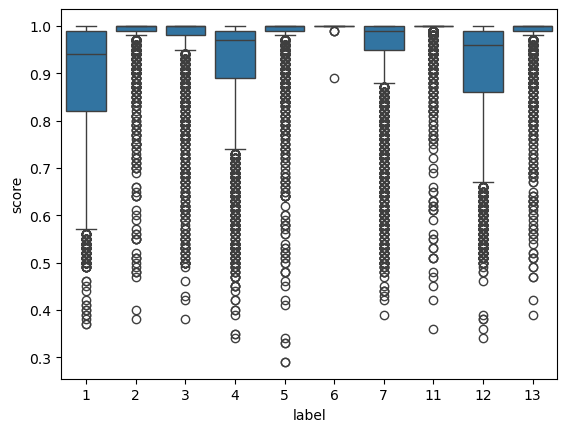

In [476]:
sns.boxplot(data=scores_df, x="label", y="score", orient="x")

In [484]:
count, bins_count = np.histogram(scores_df.score, bins=100)

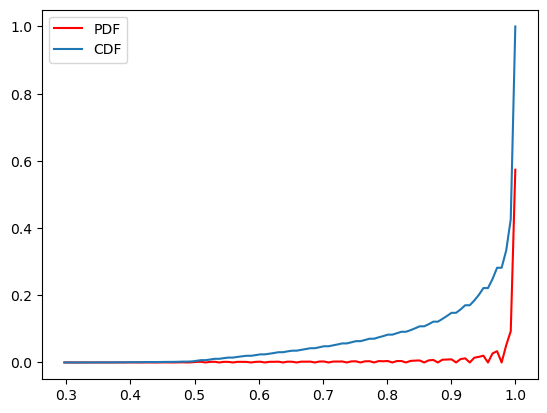

In [485]:
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 
plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
plt.plot(bins_count[1:], cdf, label="CDF") 
plt.legend()

Un classifier plutot "confiant dans sa prédiction"

* On pourrait mettre un score seuil de décision pour "accepter" la prédiction.
* Etudier le modèle multi-label

In [415]:
X_test.shape

(34179, 10)

In [431]:
pred = rf.predict(X_test)

In [432]:
accuracy_score(y_test, pred)

0.9765938149155915

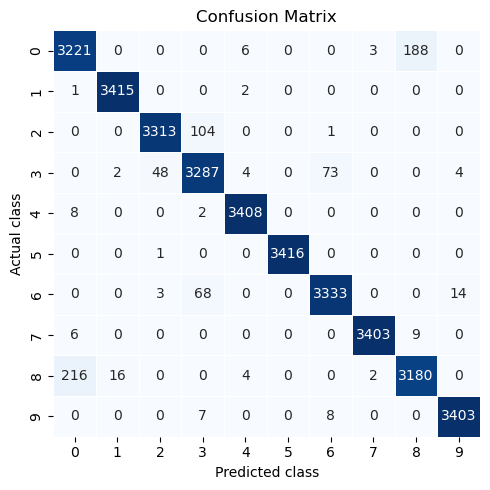

In [433]:
plot_cm(y_test, pred, target_names=None)

In [413]:
cohen_kappa_score(y_test, pred)

0.9739931276369924

In [454]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3418
           1       0.99      1.00      1.00      3418
           2       0.98      0.97      0.98      3418
           3       0.95      0.96      0.95      3418
           4       1.00      1.00      1.00      3418
           5       1.00      1.00      1.00      3417
           6       0.98      0.98      0.98      3418
           7       1.00      1.00      1.00      3418
           8       0.94      0.93      0.94      3418
           9       0.99      1.00      1.00      3418

    accuracy                           0.98     34179
   macro avg       0.98      0.98      0.98     34179
weighted avg       0.98      0.98      0.98     34179



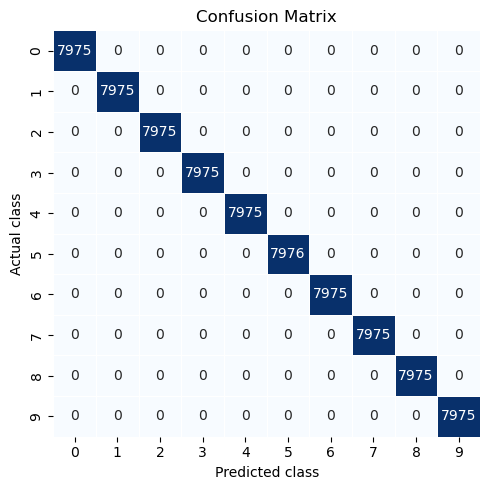

In [437]:
pred_train_rf = rf.predict(X_train)
plot_cm(y_train, pred_train_rf, target_names=None)

In [90]:
pred = np.argmax(pred_test, axis=0)

In [118]:
np.unique(pred)

array([6])

0.9882738611100644


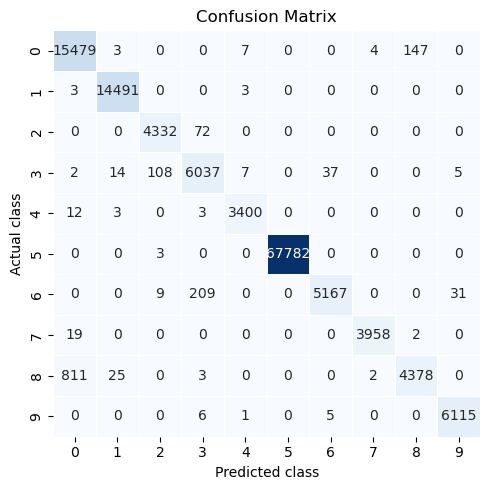

In [395]:
pred_test_knn = knn.predict(X_test)
print(accuracy_score(y_test, pred_test_knn))
plot_cm(y_test, pred_test_knn, target_names=None)

In [123]:
print(pred_test_knn)
np.unique(pred_test_knn)

[6 6 6 ... 6 6 6]


array([6])

In [393]:
pred_test_clf = clf.predict(X_test)
print(accuracy_score(y_test, pred_test_clf))


0.9645578205659595


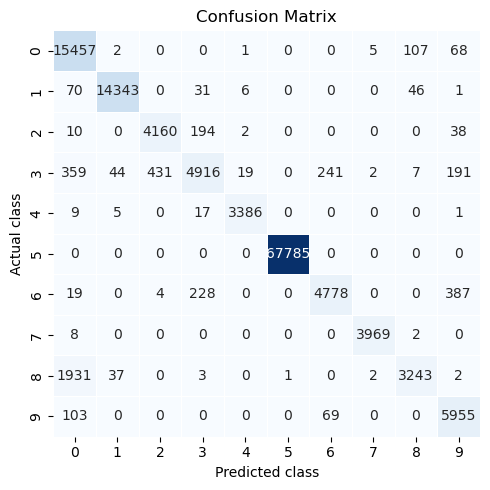

In [388]:
plot_cm(y_test, pred_test_clf, target_names=None)

In [296]:
pd.Series(pred_test_clf).value_counts()

3    23591
6     6938
7      233
dtype: int64

### Save

In [435]:
with open(os.path.join(model_dir,"rf_sk_baseline_rsmpl.pkl"), "wb") as fp:
    pickle.dump(rf, fp)

In [434]:
model_dir

'/home/rustt/Documents/Projects/S1_S2_classification/sentinel_classification/models'

### OpenCV

In [370]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=Cfg.size_test, 
    stratify=y, 
    random_state=Cfg.seed
)

In [371]:
import cv2
rtree = cv2.ml.RTrees_create()

In [372]:
 cv2.ml.ROW_SAMPLE

0

In [373]:
rtree.getVarCount()

0

In [374]:
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train);


In [375]:
_, y_hat = rtree.predict(X_test)


In [376]:
y_hat

array([[1.],
       [4.],
       [5.],
       ...,
       [5.],
       [2.],
       [9.]], dtype=float32)

In [377]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat)

0.9081427333358454

In [342]:
def plot_cm(y_test, y_pred, target_names=None): 
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sns.heatmap(cm, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues", ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    if target_names is None: 
        target_names = [str(i) for i in np.unique(y_test)]
    ax1.set_xticklabels(target_names)
    ax1.set_yticklabels(target_names)
    fig.tight_layout()

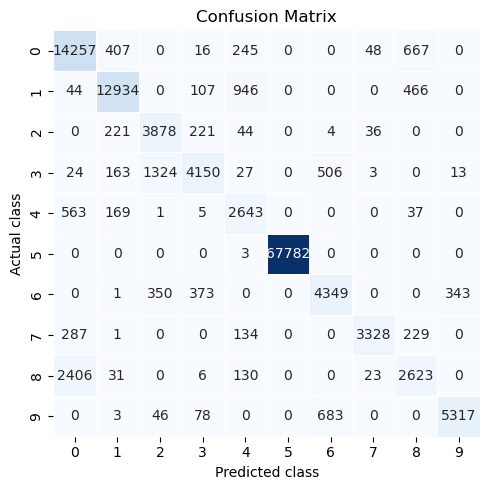

In [343]:
plot_cm(y_test, y_hat, target_names=None)

In [321]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     15640
           1       0.93      0.89      0.91     14497
           2       0.69      0.88      0.78      4404
           3       0.84      0.67      0.74      6210
           4       0.63      0.77      0.70      3418
           5       1.00      1.00      1.00     67785
           6       0.78      0.80      0.79      5416
           7       0.97      0.84      0.90      3979
           8       0.65      0.50      0.57      5219
           9       0.94      0.87      0.90      6127

    accuracy                           0.91    132695
   macro avg       0.82      0.81      0.81    132695
weighted avg       0.92      0.91      0.91    132695



### Inférence

In [324]:
pd.Series(y_test).value_counts()

5    67785
0    15640
1    14497
3     6210
9     6127
6     5416
8     5219
2     4404
7     3979
4     3418
dtype: int64

### Spetral signatures
analysis spectral signature by classes

to do

### Ressources

* pixels segmentation with skimage.feature :

https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_trainable_segmentation.html

* pixels classifciation with rggislib :

http://rsgislib.org/rsgislib_classification_classsklearn.html

* plot features importances / impurity :

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances_faces.html

* Quick Unsupervised land cover (kmeans)

https://towardsdatascience.com/unsupervised-land-cover-classification-with-python-8e3734dc3c6d

### Improvement
* LCC Sentinel 1 et 2 workflow
    * https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6427458/
    * accuracy enhancement of final classification results is the inclusion of optical indexes of vegetation, soil, water, among others [45,46,47,48]

Sentinel 2 L1C :
* https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/product-types/level-1cm
* coorection sentinel 2 : https://gitlab.orfeo-toolbox.org/orfeotoolbox/otb-documents/-/blob/master/Courses/org/WorkshopGuide/preprocessing-fr.org